In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ppscore as pps
import warnings
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
# General functions and variables

le = preprocessing.LabelEncoder()

def encode_drop(df1, df2, column_name):
    return encode_drop_per_df(df1, column_name), encode_drop_per_df(df2, column_name)

def encode_drop_per_df(df, column_name):
    df['enc_'+column_name] = le.fit_transform(df[column_name].values)
    return df.drop(column_name, axis=1)

def bar(df, column_name, aggfunc=np.median, figsize=(4,4), xrotation=0):
    pivot = df.pivot_table(index=column_name,
                  values='SalePrice', aggfunc=aggfunc)

    pivot.sort_values('SalePrice').plot(kind='bar', color='blue', figsize=figsize)
    plt.xlabel(column_name)
    plt.ylabel('Median Sale Price')
    plt.xticks(rotation=xrotation)
    plt.show()
    
def encode(df1, df2, col_name, manual_map):
    df1[col_name] = df1[col_name].map(manual_map)
    df2[col_name] = df2[col_name].map(manual_map)
    return df1, df2

def encode_corr(df1, df2, col_name):
    pivot = df1.pivot_table(index=col_name,
                      values='SalePrice', aggfunc=np.median)
    manual_map = {}
    for i, (idx, _) in enumerate(pivot.sort_values('SalePrice').iterrows()):
        manual_map[idx] = i

    return encode(df1, df2, col_name, manual_map)

def dummy(df, col):
    df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=col)
    return df.join(df_dummies)

In [3]:
# Modeling
def prep_data(df):
    df = df.select_dtypes(include=[np.number]).interpolate().dropna()
    y = np.log(df.SalePrice)
    X = df.drop(['SalePrice', 'Id'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)
    return X_train, X_test, y_train, y_test

def linear(df):
    X_train, X_test, y_train, y_test = prep_data(df)
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    return mean_squared_error(y_test, predictions, squared=False)

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
print (f"Train data shape: {train.shape}")
print (f"Test data shape: {test.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
corr_pearson = train.corr(method='pearson', min_periods=10)
corr_kendall = train.corr(method='kendall')['SalePrice']
corr_spearman = train.corr(method='spearman')['SalePrice']

<AxesSubplot:>

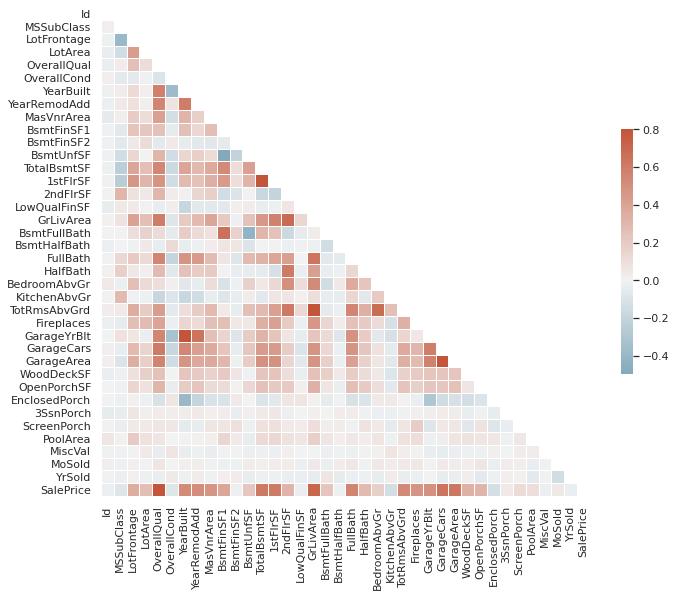

In [9]:
sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_pearson, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

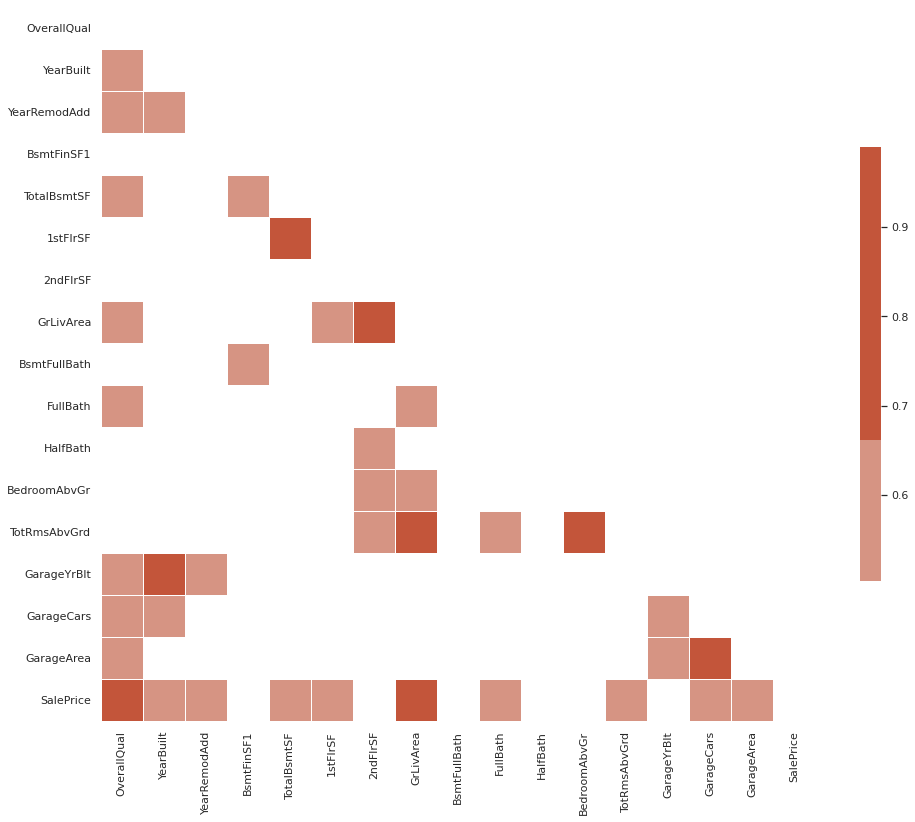

In [10]:
corr = train.corr().abs().replace(1, np.nan) \
    .apply(lambda x: np.where(x < 0.5,np.nan,x)).dropna(axis=1, how='all') \
    .apply(lambda x: np.where(x < 0.5,np.nan,x)).dropna(axis=0, how='all')

#sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# MSSubClass: Identifies the type of dwelling involved in the sale.

In [11]:
train.MSSubClass.sort_values().unique()

array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
       180, 190])

In [12]:
train.MSSubClass.value_counts(sort=True, dropna=False)

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [13]:
# Note: "150 - 1-1/2 STORY PUD - ALL AGES" is missing

In [14]:
new = [20,60,120,160]
old = [30,70]
def older_newer(x):
    if x in new:
        return 2
    elif x in old:
        return 1
    else: return 0

train['MSSubClass_OLDNEW'] = train.MSSubClass.apply(older_newer)
test['MSSubClass_OLDNEW'] = test.MSSubClass.apply(older_newer)

In [15]:
story1 = [20,30,40]
story15 = [45,50,150]
story2 = [60,70,160]
story25 = [75]

def story(x):
    if x in story1:
        return 4
    elif x in story15:
        return 3
    elif x in story2:
        return 2
    elif x in story25:
        return 1
    else: return 0

train['MSSubClass_STORY'] = train.MSSubClass.apply(story)
test['MSSubClass_STORY'] = test.MSSubClass.apply(story)

In [16]:
all_styles = [20,90,190]
all_ages = [40,45,50,75,90,150,190]
def all_styles_ages(x):
    if x in all_styles:
        return 2
    elif x in all_ages:
        return 1
    else: return 0

train['MSSubClass_STYLES_AGES'] = train.MSSubClass.apply(all_styles_ages)
test['MSSubClass_STYLES_AGES'] = test.MSSubClass.apply(all_styles_ages)

In [17]:
pud = [120,150,160,180]
train['MSSubClass_PUD'] = train.MSSubClass.apply(lambda x: 1 if x in pud else 0)
test['MSSubClass_PUD'] = test.MSSubClass.apply(lambda x: 1 if x in pud else 0)

In [18]:
attic_finished = [50]
attic_unfinished = [45]
attic_wfinished = [40]

def attic(x):
    if x in attic_finished:
        return 3
    elif x in attic_unfinished:
        return 2
    elif x in attic_wfinished:
        return 1
    else: return 0

train['MSSubClass_ATTIC'] = train.MSSubClass.apply(attic)
test['MSSubClass_ATTIC'] = test.MSSubClass.apply(attic)

In [19]:
# TODO: Study these features
split_multilevel = [80]
split_foyer = [85]
duplex = [90]
multilevel = [180]
family_conversion = [190]

def other(x):
    if x in split_multilevel:
        return 5
    elif x in split_foyer:
        return 4
    elif x in duplex:
        return 3
    elif x in multilevel:
        return 2
    elif x in family_conversion:
        return 1
    else: return 0

train['MSSubClass_OTHER'] = train.MSSubClass.apply(other)
test['MSSubClass_OTHER'] = test.MSSubClass.apply(other)

In [20]:
train.drop("MSSubClass",inplace=True, axis=1)
test.drop("MSSubClass",inplace=True, axis=1)
version = 'MSSubClass-dropped'

# MSZoning: Identifies the general zoning classification of the sale.

In [21]:
np.sort(train.MSZoning.unique())

array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object)

In [22]:
train.MSZoning.value_counts(sort=True, dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [23]:
test.MSZoning.value_counts(sort=True, dropna=False)

RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: MSZoning, dtype: int64

In [24]:
quality_pivot = train.pivot_table(index='MSZoning',
                  values='SalePrice', aggfunc=np.median)

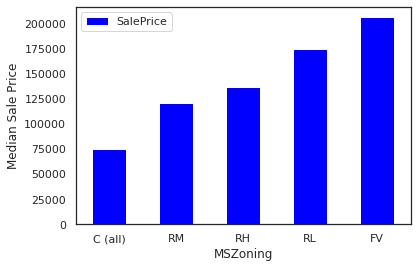

In [25]:
quality_pivot.sort_values('SalePrice').plot(kind='bar', color='blue')
plt.xlabel('MSZoning')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [26]:
featler = ['RH','RL','RP','RM',]
train['MSZoning_Residential'] = train.MSZoning.apply(lambda x: 1 if x in featler else 0)
test['MSZoning_Residential'] = test.MSZoning.apply(lambda x: 1 if x in featler else 0)

In [27]:
def density(x):
    if x in ['RH']:
        return 1
    elif  x in ['RM']:
        return 2
    elif x in ['RL']:
        return 3
    elif x in ['RP']:
        return 4
    else: return 0

train['MSZoning_Density'] = train.MSZoning.apply(density)
test['MSZoning_Density'] = test.MSZoning.apply(density)

In [28]:
featler = ['FV']
train['MSZoning_FloatingVillage'] = train.MSZoning.apply(lambda x: 1 if x in featler else 0)
test['MSZoning_FloatingVillage'] = test.MSZoning.apply(lambda x: 1 if x in featler else 0)

In [29]:
train.drop("MSZoning",inplace=True, axis=1)
test.drop("MSZoning",inplace=True, axis=1)

# Lot Frontage: Linear feet of street connected to property

In [30]:
train.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [31]:
train.LotFrontage.sort_values().unique()

array([ 21.,  24.,  30.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 114., 115., 116., 118.,
       120., 121., 122., 124., 128., 129., 130., 134., 137., 138., 140.,
       141., 144., 149., 150., 152., 153., 160., 168., 174., 182., 313.,
        nan])

Text(0.5, 0, 'Test')

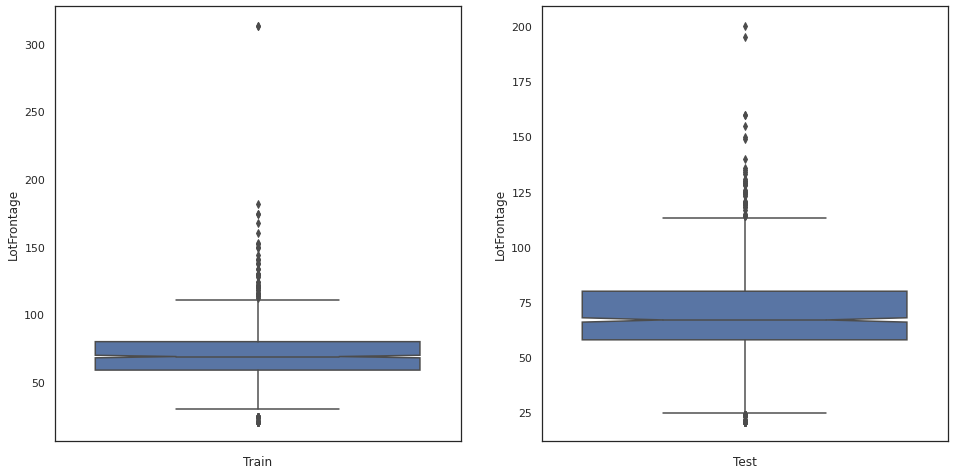

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
sns.boxplot(ax=ax[0], y=train.LotFrontage, notch= True, showfliers=True)
sns.boxplot(ax=ax[1], y=test.LotFrontage, notch= True, showfliers=True)

ax[0].set_xlabel("Train", fontsize= 12)
ax[1].set_xlabel("Test", fontsize= 12)

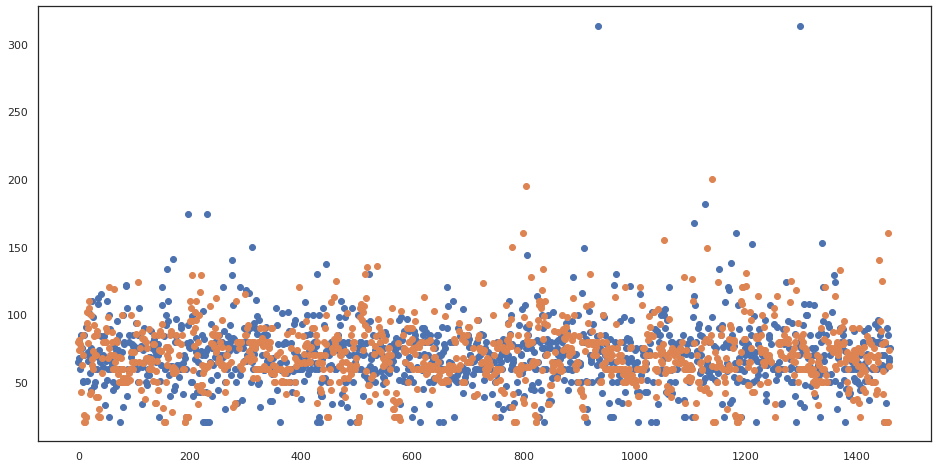

In [33]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.scatter(range(len(train.LotFrontage)), train.LotFrontage)
ax1.scatter(range(len(test.LotFrontage)), test.LotFrontage)

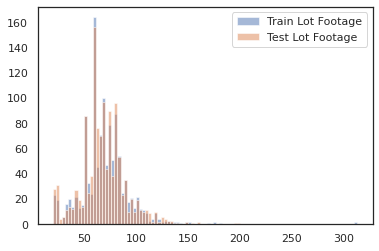

In [34]:
bins = np.linspace(20, 313, 100)

plt.hist(train.LotFrontage, bins, alpha=0.5, label='Train Lot Footage')
plt.hist(test.LotFrontage, bins, alpha=0.5, label='Test Lot Footage')
plt.legend(loc='upper right')
plt.show()

In [35]:
train.LotFrontage.fillna(0, inplace=True)
test.LotFrontage.fillna(0, inplace=True)

In [36]:
# Note: No outlier

# Lot Area: Lot size in square feet

In [37]:
df = train.LotArea.to_frame(name = 'Train Lot Area').join(test.LotArea.to_frame(name='Test Lot Area')) 
df.describe()

,Train Lot Area,Test Lot Area
count,1460.000000,1459.000000
mean,10516.828082,9819.161069
std,9981.264932,4955.517327
min,1300.000000,1470.000000
25%,7553.500000,7391.000000
50%,9478.500000,9399.000000
75%,11601.500000,11517.500000
max,215245.000000,56600.000000


Text(0.5, 0, 'Test')

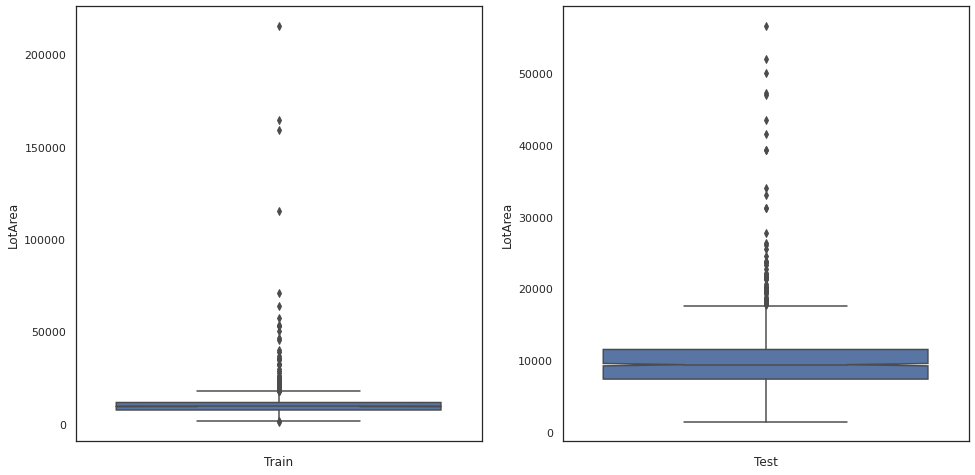

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
sns.boxplot(ax=ax[0], y=train.LotArea, notch= True, showfliers=True)
sns.boxplot(ax=ax[1], y=test.LotArea, notch= True, showfliers=True)

ax[0].set_xlabel("Train", fontsize= 12)
ax[1].set_xlabel("Test", fontsize= 12)

In [39]:
# Outlier
train = train[train.LotArea <= 56600]

# Street: Type of road access to property

In [40]:
df = train.Street.to_frame(name = 'Train Street').join(test.Street.to_frame(name='Test Street')) 
df.describe()

,Train Street,Test Street
count,1453,1452
unique,2,2
top,Pave,Pave
freq,1448,1446


In [41]:
print(train.Street.unique())

['Pave' 'Grvl']


In [42]:
train.Street.value_counts(sort=True, dropna=False)

Pave    1448
Grvl       5
Name: Street, dtype: int64

In [43]:
train, test = encode_drop(train, test, "Street")

# Alley: Type of alley access to property

In [44]:
train.Alley.value_counts(sort=True, dropna=False)

NaN     1362
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [45]:
test.Alley.value_counts(sort=True, dropna=False)

NaN     1352
Grvl      70
Pave      37
Name: Alley, dtype: int64

In [46]:
train.Alley.fillna("No Alley", inplace=True)
test.Alley.fillna("No Alley", inplace=True)

In [47]:
train, test = encode_drop(train, test, "Alley")

# Lot Shape: General shape of property

In [48]:
train.LotShape.value_counts(sort=True, dropna=False)

Reg    925
IR1    481
IR2     39
IR3      8
Name: LotShape, dtype: int64

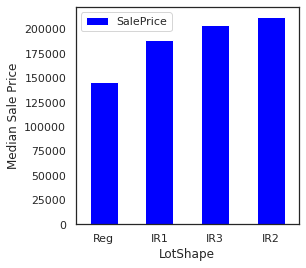

In [49]:
bar(train, "LotShape")

In [50]:
# Testing different encodings
train, test = encode(train, test, "LotShape", {"Reg":0, "IR3":1, "IR1":2, "IR2": 3})
#train = pd.get_dummies(train, columns = ['LotShape'])
#test = pd.get_dummies(test, columns = ['LotShape'])
#train, test = encode_corr(train, test, "LotShape")
#train, test = encode_drop(train, test, "LotShape")

# Land Contour: Flatness of the property

In [51]:
train.LandContour.value_counts(sort=True, dropna=False)

Lvl    1311
Bnk      61
HLS      49
Low      32
Name: LandContour, dtype: int64

In [52]:
test.LandContour.value_counts(sort=True, dropna=False)

Lvl    1311
HLS      70
Bnk      54
Low      24
Name: LandContour, dtype: int64

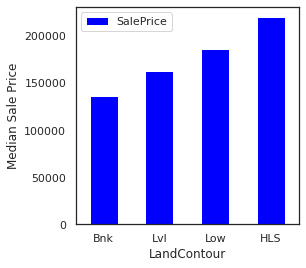

In [53]:
bar(train, "LandContour")

In [54]:
#train, test = encode_drop(train, test, "LandContour")

In [55]:
# Testing different encodings
#train, test = encode(train, test, "LandContour", {"Low":0, "HLS":1, "Bnk":2, "Lvl":3})
#train = pd.get_dummies(train, columns = ['LandContour'])
#test = pd.get_dummies(test, columns = ['LandContour'])
#train, test = encode_corr(train, test, "LandContour")
train, test = encode_drop(train, test, "LandContour")

# Utilities

In [56]:
train.Utilities.value_counts(sort=True, dropna=False)

AllPub    1452
NoSeWa       1
Name: Utilities, dtype: int64

In [57]:
test.Utilities.value_counts(sort=True, dropna=False)

AllPub    1457
NaN          2
Name: Utilities, dtype: int64

In [58]:
#train['enc_utilities'] = pd.get_dummies(train.Utilities, drop_first=True)
#test['enc_utilities'] = pd.get_dummies(train.Utilities, drop_first=True)

In [59]:
#train.drop("Utilities",inplace=True, axis=1)
#test.drop("Utilities",inplace=True, axis=1)

# Lot Config

In [60]:
train.LotConfig.value_counts(sort=True, dropna=False)

Inside     1049
Corner      261
CulDSac      92
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [61]:
test.LotConfig.value_counts(sort=True, dropna=False)

Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: LotConfig, dtype: int64

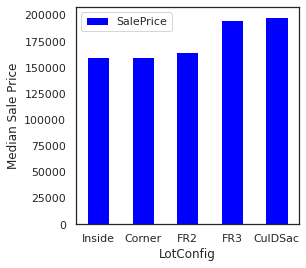

In [62]:
bar(train, "LotConfig")

In [63]:
# Manually encoding - follow Median order
manual_map = {"Inside":0, 
                 "Corner":1,
                 "FR2":2, 
                 "FR3":3, 
                 "CulDSac":4}

train['LotConfig'] = train['LotConfig'].map(manual_map)
test['LotConfig'] = test['LotConfig'].map(manual_map)

# Land Slope

In [64]:
train.LandSlope.value_counts(sort=True, dropna=False)

Gtl    1381
Mod      64
Sev       8
Name: LandSlope, dtype: int64

In [65]:
test.LandSlope.value_counts(sort=True, dropna=False)

Gtl    1396
Mod      60
Sev       3
Name: LandSlope, dtype: int64

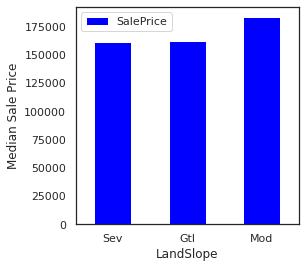

In [66]:
bar(train, "LandSlope")

In [67]:
# Manually encoding - follow Median order
manual_map = {"Gtl":0, 
                 "Sev":1,
                 "Mod":2}

train, test = encode(train, test, 'LandSlope', manual_map)

# Neighborhood

In [68]:
train.Neighborhood.value_counts(sort=True, dropna=False)

NAmes      225
CollgCr    150
OldTown    113
Edwards     99
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
IDOTRR      37
Timber      35
ClearCr     25
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [69]:
test.Neighborhood.value_counts(sort=True, dropna=False)

NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
BrDale      14
NPkVill     14
Veenker     13
Blmngtn     11
Blueste      8
Name: Neighborhood, dtype: int64

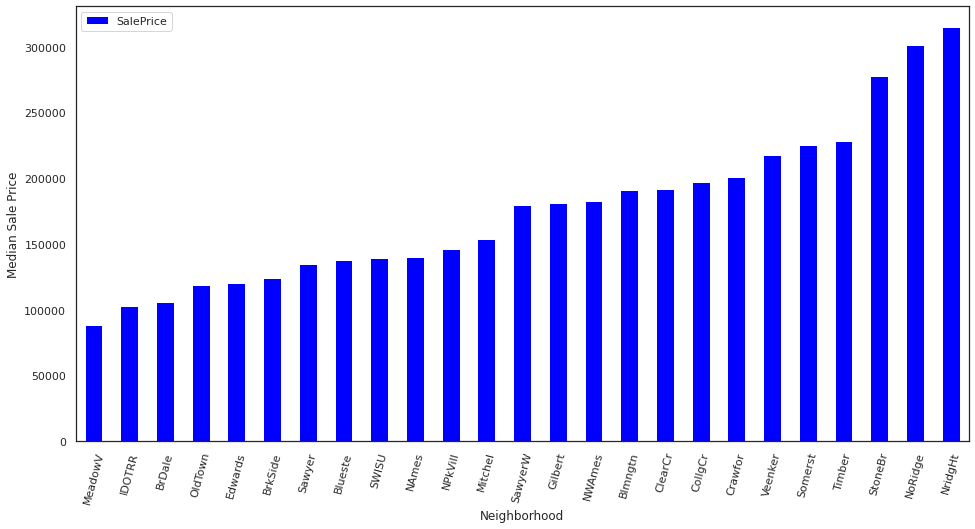

In [70]:
bar(train, "Neighborhood", figsize=(16,8), xrotation=75)

In [71]:
# Manually encoding - follow Median order
pivot = train.pivot_table(index="Neighborhood",
                  values='SalePrice', aggfunc=np.median)
manual_map = {}
for i, (idx, _) in enumerate(pivot.sort_values('SalePrice').iterrows()):
    manual_map[idx] = i

train, test = encode(train, test, 'Neighborhood', manual_map)

In [72]:
# Neighborhood -> Nominal
#train = pd.get_dummies(train, columns = ['Neighborhood'])
#test = pd.get_dummies(test, columns = ['Neighborhood'])

# Condition1: Proximity to various conditions

In [73]:
train.Condition1.value_counts(sort=True, dropna=False)

Norm      1254
Feedr       80
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [74]:
test.Condition1.value_counts(sort=True, dropna=False)

Norm      1251
Feedr       83
Artery      44
RRAn        24
PosN        20
RRAe        17
PosA        12
RRNn         4
RRNe         4
Name: Condition1, dtype: int64

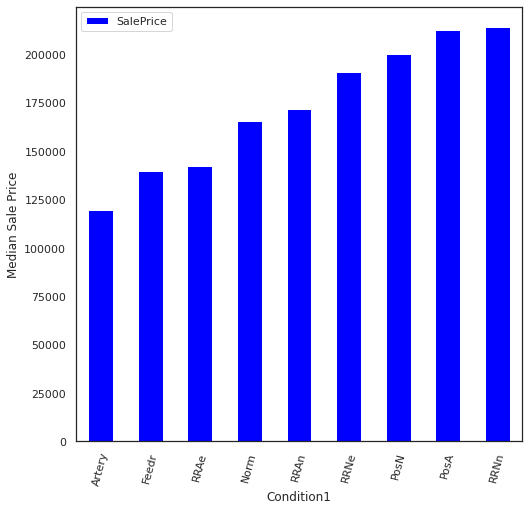

In [75]:
bar(train, "Condition1", figsize=(8,8), xrotation=75)

In [76]:
train = pd.get_dummies(train, columns = ['Condition1'])
test = pd.get_dummies(test, columns = ['Condition1'])

# Condition2: Proximity to various conditions (if more than one is present)

In [77]:
train.Condition2.value_counts(sort=True, dropna=False)

Norm      1438
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64

In [78]:
test.Condition2.value_counts(sort=True, dropna=False)

Norm      1444
Feedr        7
PosA         3
Artery       3
PosN         2
Name: Condition2, dtype: int64

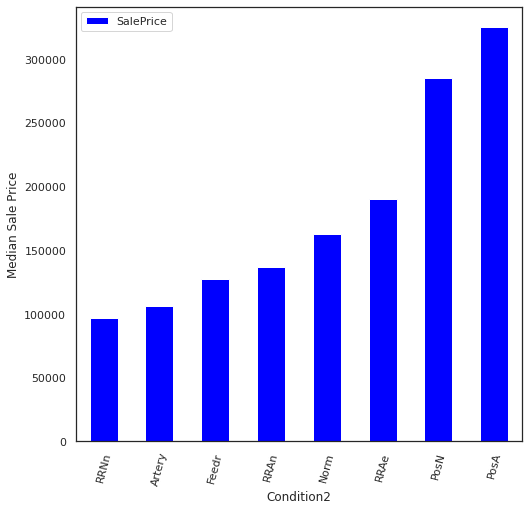

In [79]:
bar(train, "Condition2", figsize=(8,8), xrotation=75)

In [80]:
train = pd.get_dummies(train, columns = ['Condition2'])
test = pd.get_dummies(test, columns = ['Condition2'])

# BldgType: Type of dwelling

In [81]:
train.BldgType.value_counts(sort=True, dropna=False)

1Fam      1214
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      30
Name: BldgType, dtype: int64

In [82]:
test.BldgType.value_counts(sort=True, dropna=False)

1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: BldgType, dtype: int64

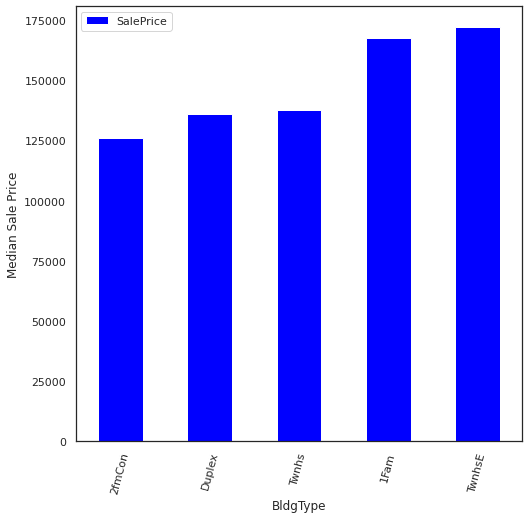

In [83]:
bar(train, "BldgType", figsize=(8,8), xrotation=75)

In [84]:
#train, test = encode_drop(train, test, "BldgType")

In [85]:
train = pd.get_dummies(train, columns = ['BldgType'])
test = pd.get_dummies(test, columns = ['BldgType'])

# HouseStyle: Style of dwelling

In [86]:
train.HouseStyle.value_counts(sort=True, dropna=False)

1Story    722
2Story    444
1.5Fin    152
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

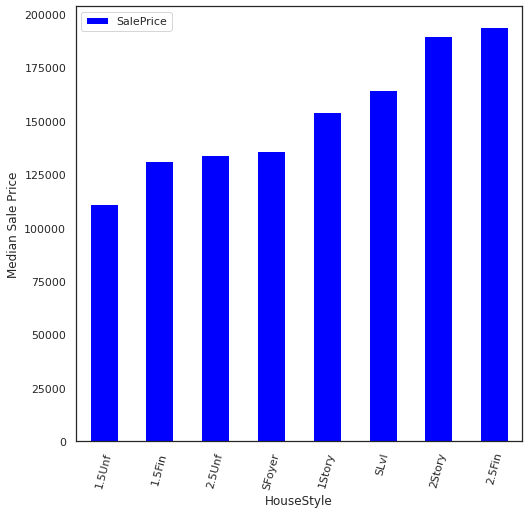

In [87]:
bar(train, "HouseStyle", figsize=(8,8), xrotation=75)

In [88]:
# Manually encoding - follow Median order
pivot = train.pivot_table(index="HouseStyle",
                  values='SalePrice', aggfunc=np.median)
manual_map = {}
for i, (idx, _) in enumerate(pivot.sort_values('SalePrice').iterrows()):
    manual_map[idx] = i

train, test = encode(train, test, 'HouseStyle', manual_map)

In [89]:
# TODO Split between finished and unfinished

In [90]:
story1 = ["1Story"]
story15 = ["1.5Fin", "1.5Unf"]
story2 = ["2.5Fin"]
story25 = ["2.5Unf"]

def story(x):
    if x in story25:
        return 4
    elif x in story2:
        return 3
    elif x in story15:
        return 2
    elif x in story1:
        return 1
    else: return 0

#train['HouseStyle_STORY'] = train.HouseStyle.apply(story)
#test['HouseStyle_STORY'] = test.HouseStyle.apply(story)

In [91]:
sFoyer = ["SFoyer"]
sLvl = ["SLvl"]

def foyer(x):
    if x in sLvl:
        return 2
    elif x in sFoyer:
        return 1
    else: return 0

#train['HouseStyle_FOYER'] = train.HouseStyle.apply(foyer)
#test['HouseStyle_FOYER'] = test.HouseStyle.apply(foyer)

In [92]:
#train['HouseStyle_FINISHED'] = train.HouseStyle.apply(lambda x: 1 if x in ["1.5Fin", "2.5Fin"] else 0)
#test['HouseStyle_UNFINISHED'] = test.HouseStyle.apply(lambda x: 1 if x in ["1.5Unf", "2.5Unf"] else 0)

In [93]:
#train.drop("HouseStyle",inplace=True, axis=1)
#test.drop("HouseStyle",inplace=True, axis=1)

# OverallQual: Rates the overall material and finish of the house

In [94]:
train.OverallQual.value_counts(sort=True, dropna=False)

5     395
6     373
7     316
8     168
4     116
9      43
3      20
10     17
2       3
1       2
Name: OverallQual, dtype: int64

In [95]:
train['enc_OverallQual'] = le.fit_transform(train.OverallQual.values)
test['enc_OverallQual'] = le.fit_transform(test.OverallQual.values)

In [96]:
train.drop("OverallQual",inplace=True, axis=1)
test.drop("OverallQual",inplace=True, axis=1)

# OverallCond: Rates the overall condition of the house

In [97]:
train.OverallCond.value_counts(sort=True, dropna=False)

5    816
6    251
7    204
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [98]:
train, test = encode_drop(train, test, "OverallCond")

# Year Built: Original construction date

In [99]:
train.YearBuilt.value_counts(sort=True, dropna=False)

2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1904     1
1898     1
1893     1
1882     1
2010     1
Name: YearBuilt, Length: 112, dtype: int64

In [100]:
# Normalization has no impact om perf
#train.YearBuilt = (train.YearBuilt-train.YearBuilt.mean())/train.YearBuilt.std()

# YearRemodAdd: Remodel date
####  (same as construction date if no remodeling or additions)

In [101]:
train.YearRemodAdd.value_counts(sort=True, dropna=False)

1950    177
2006     96
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1986      5
1952      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64

In [102]:
# Normalization has no impact on perf
#train.YearRemodAdd = (train.YearRemodAdd-train.YearRemodAdd.mean())/train.YearRemodAdd.std()

# RoofStyle: Type of roof

In [103]:
train.RoofStyle.value_counts(sort=True, dropna=False)

Gable      1136
Hip         284
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

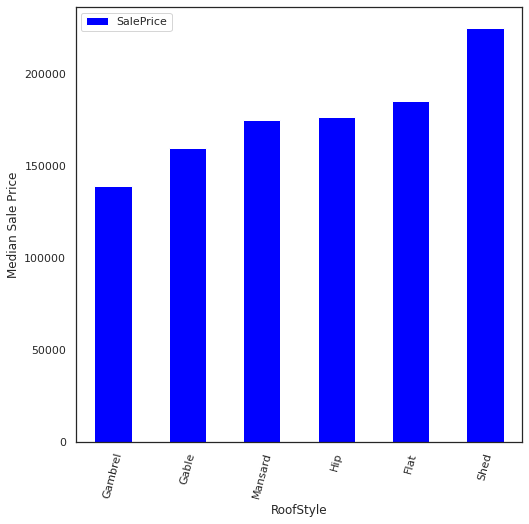

In [104]:
bar(train, "RoofStyle", figsize=(8,8), xrotation=75)

In [105]:
train, test = encode_drop(train, test, "RoofStyle")

# RoofMatl: Roof material

In [106]:
train.RoofMatl.value_counts(sort=True, dropna=False)

CompShg    1429
Tar&Grv      11
WdShngl       5
WdShake       5
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

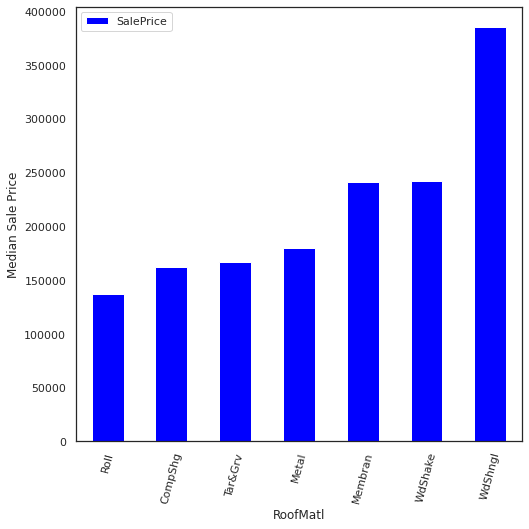

In [107]:
bar(train, "RoofMatl", figsize=(8,8), xrotation=75)

In [108]:
train = pd.get_dummies(train, columns = ['RoofMatl'])
test = pd.get_dummies(test, columns = ['RoofMatl'])

# Exterior1st: Exterior covering on house

In [109]:
train.Exterior1st.value_counts(sort=True, dropna=False)

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    204
Plywood    105
CemntBd     61
BrkFace     49
WdShing     26
Stucco      24
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

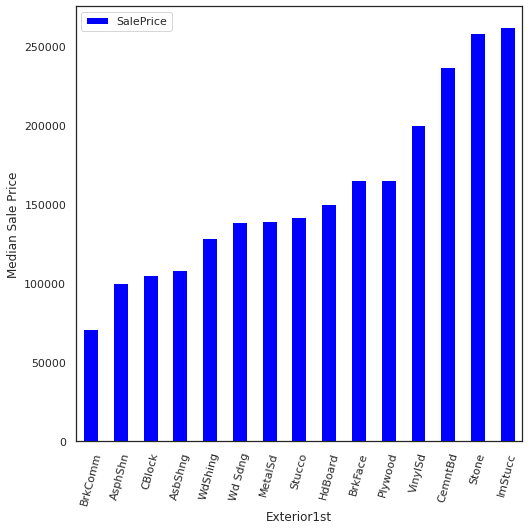

In [110]:
bar(train, "Exterior1st", figsize=(8,8), xrotation=75)

In [111]:
# TODO: Study the different materials
# Warning: encoding negatively impact the performance

# Exterior2nd: Exterior covering on house (if more than one material)

In [112]:
train.Exterior2nd.value_counts(sort=True, dropna=False)

VinylSd    504
MetalSd    214
HdBoard    206
Wd Sdng    196
Plywood    139
CmentBd     60
Wd Shng     38
Stucco      25
BrkFace     24
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [113]:
# Warning: negatively impact the performance
#train, test = encode_drop(train, test, "Exterior2nd")

# MasVnrType: Masonry veneer type

In [114]:
train.MasVnrType.value_counts(sort=True, dropna=False)

None       860
BrkFace    445
Stone      126
BrkCmn      14
NaN          8
Name: MasVnrType, dtype: int64

In [115]:
train.MasVnrType.fillna("Other", inplace=True)
test.MasVnrType.fillna("Other", inplace=True)

In [116]:
# Testing different encodings
train = pd.get_dummies(train, columns = ['MasVnrType'])
test = pd.get_dummies(test, columns = ['MasVnrType'])
#train, test = encode_corr(train, test, "MasVnrType")
#train, test = encode_drop(train, test, "MasVnrType")

# MasVnrArea: Masonry veneer area in square feet

In [117]:
train.MasVnrArea.value_counts(sort=True, dropna=False)

0.0       857
108.0       8
72.0        8
NaN         8
180.0       8
         ... 
653.0       1
102.0       1
315.0       1
1170.0      1
415.0       1
Name: MasVnrArea, Length: 327, dtype: int64

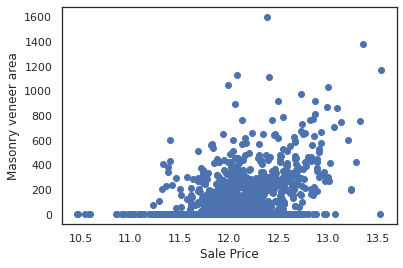

In [118]:
plt.scatter(x=np.log(train.SalePrice), y=train.MasVnrArea)
plt.xlabel('Sale Price')
plt.ylabel('Masonry veneer area')
plt.show()

In [119]:
train.MasVnrArea.fillna(0, inplace=True)
test.MasVnrArea.fillna(0, inplace=True)

# ExterQual: Evaluates the quality of the material on the exterior 

In [120]:
train.ExterQual.value_counts(sort=True, dropna=False)

TA    901
Gd    487
Ex     51
Fa     14
Name: ExterQual, dtype: int64

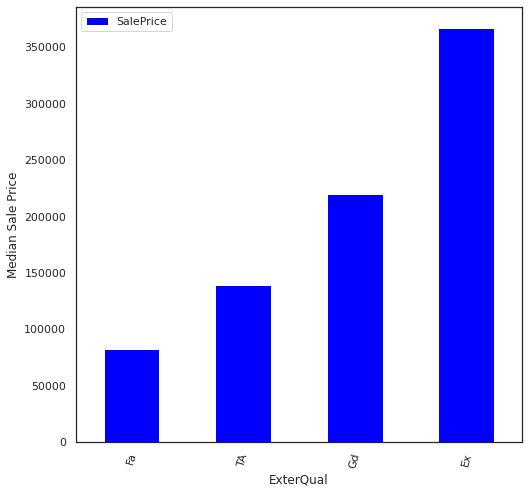

In [121]:
bar(train, "ExterQual", figsize=(8,8), xrotation=75)

In [122]:
# Warning: negatively impact the performance
# Testing different encodings
train, test = encode(train, test, "ExterQual", {"TA": 2, "Gd": 3, "Ex": 4, "Fa":1, "Po":0})
#train = pd.get_dummies(train, columns = ['ExterQual'])
#test = pd.get_dummies(test, columns = ['ExterQual'])
#train, test = encode_corr(train, test, "ExterQual")
#train, test = encode_drop(train, test, "ExterQual")

# ExterCond: Evaluates the present condition of the material on the exterior

In [123]:
train.ExterCond.value_counts(sort=True, dropna=False)

TA    1275
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [124]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "ExterCond", {"TA": 2, "Gd": 3, "Ex": 4, "Fa":1, "Po":0})
#train = pd.get_dummies(train, columns = ['ExterCond'])
#test = pd.get_dummies(test, columns = ['ExterCond'])
train, test = encode_corr(train, test, "ExterCond")
#train, test = encode_drop(train, test, "ExterCond")

# Foundation: Type of foundation

In [125]:
train.Foundation.value_counts(sort=True, dropna=False)

PConc     646
CBlock    628
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [126]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "Foundation", {"TA": 2, "Gd": 3, "Ex": 4, "Fa":1, "Po":0})
#train = pd.get_dummies(train, columns = ['Foundation'])
#test = pd.get_dummies(test, columns = ['Foundation'])
train, test = encode_corr(train, test, "Foundation")
#train, test = encode_drop(train, test, "Foundation")

# BsmtQual: Evaluates the height of the basement

In [127]:
train.BsmtQual.value_counts(sort=True, dropna=False)

TA     647
Gd     614
Ex     120
NaN     37
Fa      35
Name: BsmtQual, dtype: int64

In [128]:
train.BsmtQual.fillna("NoBsmt", inplace=True)
test.BsmtQual.fillna("NoBsmt", inplace=True)

In [129]:
# Warning: negatively impact the performance
# Testing different encodings
train, test = encode(train, test, "BsmtQual", {"TA": 3, "Gd": 4, "Ex": 5, "Fa":2, "Po":1, "NoBsmt":0})
#train = pd.get_dummies(train, columns = ['BsmtQual'])
#test = pd.get_dummies(test, columns = ['BsmtQual'])
#train, test = encode_corr(train, test, "BsmtQual")
#train, test = encode_drop(train, test, "BsmtQual")

# BsmtCond: Evaluates the general condition of the basement

In [130]:
train.BsmtCond.value_counts(sort=True, dropna=False)

TA     1304
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64

In [131]:
train.BsmtCond.fillna("NoBsmt", inplace=True)
test.BsmtCond.fillna("NoBsmt", inplace=True)

In [132]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "BsmtCond", {"TA": 3, "Gd": 4, "Ex": 5, "Fa":2, "Po":1, "NoBsmt":0})
#train = pd.get_dummies(train, columns = ['BsmtCond'])
#test = pd.get_dummies(test, columns = ['BsmtCond'])
#train, test = encode_corr(train, test, "BsmtCond")
train, test = encode_drop(train, test, "BsmtCond")

# BsmtExposure: Refers to walkout or garden level walls

In [133]:
train.BsmtExposure.value_counts(sort=True, dropna=False)

No     953
Av     220
Gd     128
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64

In [134]:
train.BsmtExposure.fillna("NoBsmt", inplace=True)
test.BsmtExposure.fillna("NoBsmt", inplace=True)

In [135]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "BsmtExposure", {"NoBsmt":0, "No":1, "Mn":2, "Av":3, "Gd":4})
#train = pd.get_dummies(train, columns = ['BsmtExposure'])
#test = pd.get_dummies(test, columns = ['BsmtExposure'])
#train, test = encode_corr(train, test, "BsmtExposure")
train, test = encode_drop(train, test, "BsmtExposure")

# BsmtFinType1: Rating of basement finished area

In [136]:
train.BsmtFinType1.value_counts(sort=True, dropna=False)

Unf    430
GLQ    416
ALQ    217
BLQ    147
Rec    132
LwQ     74
NaN     37
Name: BsmtFinType1, dtype: int64

In [137]:
train.BsmtFinType1.fillna("NoBsmt", inplace=True)
test.BsmtFinType1.fillna("NoBsmt", inplace=True)

In [138]:
# Warning: negatively impact the performance
# Testing different encodings
train, test = encode(train, test, "BsmtFinType1", {"NoBsmt":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":3, "ALQ":4, "GLQ":5})
#train = pd.get_dummies(train, columns = ['BsmtFinType1'])
#test = pd.get_dummies(test, columns = ['BsmtFinType1'])
#train, test = encode_corr(train, test, "BsmtFinType1")
#train, test = encode_drop(train, test, "BsmtFinType1")

# BsmtFinSF1: Type 1 finished square feet

In [139]:
train.BsmtFinSF1.value_counts(sort=True, dropna=False)

0       467
24       12
16        9
20        5
686       5
       ... 
679       1
678       1
673       1
270       1
2096      1
Name: BsmtFinSF1, Length: 635, dtype: int64

# BsmtFinType2: Rating of basement finished area (if multiple types)

In [140]:
train.BsmtFinType2.value_counts(sort=True, dropna=False)

Unf    1252
Rec      52
LwQ      46
NaN      38
BLQ      32
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [141]:
train.BsmtFinType2.fillna("NoBsmt", inplace=True)
test.BsmtFinType2.fillna("NoBsmt", inplace=True)

In [142]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "BsmtFinType2", {"NoBsmt":0, "Unf":1, "LwQ":2, "BLQ":3, "ALQ":4, "GLQ":4})
#train = pd.get_dummies(train, columns = ['BsmtFinType2'])
#test = pd.get_dummies(test, columns = ['BsmtFinType2'])
train, test = encode_corr(train, test, "BsmtFinType2")
#train, test = encode_drop(train, test, "BsmtFinType2")

# BsmtFinSF2: Type 2 finished square feet

In [143]:
train.BsmtFinSF2.value_counts(sort=True, dropna=False)

0       1289
180        5
374        3
468        2
279        2
        ... 
211        1
210        1
208        1
202        1
1474       1
Name: BsmtFinSF2, Length: 142, dtype: int64

# BsmtUnfSF: Unfinished square feet of basement area

In [144]:
train.BsmtUnfSF.value_counts(sort=True, dropna=False)

0       118
728       9
384       8
300       7
572       7
       ... 
548       1
545       1
543       1
542       1
2046      1
Name: BsmtUnfSF, Length: 779, dtype: int64

# TotalBsmtSF: Total square feet of basement area

In [145]:
train.TotalBsmtSF.value_counts(sort=True, dropna=False)

0       37
864     35
672     17
912     15
1040    14
        ..
1203     1
1202     1
736      1
738      1
2046     1
Name: TotalBsmtSF, Length: 716, dtype: int64

# Heating: Type of heating

In [146]:
train.Heating.value_counts(sort=True, dropna=False)

GasA     1422
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [147]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "Heating", {"Wall":0, "OthW":1, "Grav":2, "GasW":3, "GasA":4, "Floor":5})
#train = pd.get_dummies(train, columns = ['Heating'])
#test = pd.get_dummies(test, columns = ['Heating'])
#train, test = encode_corr(train, test, "Heating")
#train, test = encode_drop(train, test, "Heating")

# HeatingQC: Heating quality and condition

In [148]:
train.HeatingQC.value_counts(sort=True, dropna=False)

Ex    739
TA    424
Gd    240
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [149]:
# Testing different encodings
#train, test = encode(train, test, "HeatingQC", {"Po":0, "Fa":1, "TA": 2, "Gd": 3, "Ex": 4})
#train = pd.get_dummies(train, columns = ['HeatingQC'])
#test = pd.get_dummies(test, columns = ['HeatingQC'])
train, test = encode_corr(train, test, "HeatingQC")
#train, test = encode_drop(train, test, "HeatingQC")

# CentralAir: Central air conditioning

In [150]:
train.CentralAir.value_counts(sort=True, dropna=False)

Y    1358
N      95
Name: CentralAir, dtype: int64

In [151]:
# Testing different encodings
#train, test = encode(train, test, "CentralAir", {"Y":1, "N":0})
#train = pd.get_dummies(train, columns = ['CentralAir'])
#test = pd.get_dummies(test, columns = ['CentralAir'])
#train, test = encode_corr(train, test, "CentralAir")
#train, test = encode_drop(train, test, "CentralAir")

# Electrical: Electrical system

In [152]:
train.Electrical.value_counts(sort=True, dropna=False)

SBrkr    1327
FuseA      94
FuseF      27
FuseP       3
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [153]:
# Testing different encodings
#train, test = encode(train, test, "Electrical", {"Mix":0, "FuseP":1, "FuseF":2, "FuseA":3, "SBrkr":4})
#train = pd.get_dummies(train, columns = ['Electrical'])
#test = pd.get_dummies(test, columns = ['Electrical'])
#train, test = encode_corr(train, test, "Electrical")
train, test = encode_drop(train, test, "Electrical")

# 1stFlrSF: First Floor square feet

In [154]:
train["1stFlrSF"].value_counts(sort=True, dropna=False)

864     25
1040    16
912     14
848     12
894     12
        ..
1061     1
1058     1
1051     1
1047     1
2046     1
Name: 1stFlrSF, Length: 747, dtype: int64

# 2ndFlrSF: Second floor square feet

In [155]:
train["2ndFlrSF"].value_counts(sort=True, dropna=False)

0       825
728      10
504       9
672       8
546       8
       ... 
767       1
766       1
761       1
351       1
1872      1
Name: 2ndFlrSF, Length: 414, dtype: int64

# LowQualFinSF: Low quality finished square feet (all floors)

In [156]:
train.LowQualFinSF.value_counts(sort=True, dropna=False)

0      1427
80        3
360       2
392       1
528       1
515       1
514       1
513       1
481       1
479       1
473       1
420       1
397       1
390       1
53        1
384       1
371       1
234       1
232       1
205       1
156       1
144       1
120       1
572       1
Name: LowQualFinSF, dtype: int64

# GrLivArea: Above grade (ground) living area square feet

# BsmtFullBath: Basement full bathrooms

In [157]:
train.BsmtFullBath.value_counts(sort=True, dropna=False)

0    855
1    585
2     12
3      1
Name: BsmtFullBath, dtype: int64

# BsmtHalfBath: Basement half bathrooms

In [158]:
train.BsmtHalfBath.value_counts(sort=True, dropna=False)

0    1372
1      79
2       2
Name: BsmtHalfBath, dtype: int64

# FullBath: Full bathrooms above grade

In [159]:
train.FullBath.value_counts(sort=True, dropna=False)

2    762
1    649
3     33
0      9
Name: FullBath, dtype: int64

# HalfBath: Half baths above grade

In [160]:
train.HalfBath.value_counts(sort=True, dropna=False)

0    907
1    534
2     12
Name: HalfBath, dtype: int64

# Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

In [161]:
train.BedroomAbvGr.value_counts(sort=True, dropna=False)

3    800
2    356
4    212
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

# Kitchen: Kitchens above grade

In [162]:
train.KitchenAbvGr.value_counts(sort=True, dropna=False)

1    1385
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

# KitchenQual: Kitchen quality

In [163]:
train.KitchenQual.value_counts(sort=True, dropna=False)

TA    732
Gd    583
Ex     99
Fa     39
Name: KitchenQual, dtype: int64

In [164]:
# Testing different encodings
#train, test = encode(train, test, "KitchenQual", {"Po":0, "Fa":1, "TA": 2, "Gd": 3, "Ex": 4})
train = pd.get_dummies(train, columns = ['KitchenQual'])
test = pd.get_dummies(test, columns = ['KitchenQual'])
#train, test = encode_corr(train, test, "KitchenQual")
#train, test = encode_drop(train, test, "KitchenQual")

# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

In [165]:
train.TotRmsAbvGrd.value_counts(sort=True, dropna=False)

6     402
7     326
5     273
8     186
4      97
9      75
10     47
11     18
3      17
12     10
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64

# Functional: Home functionality (Assume typical unless deductions are warranted)

In [166]:
train.Functional.value_counts(sort=True, dropna=False)

Typ     1354
Min2      34
Min1      30
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [167]:
# Testing different encodings
train, test = encode(train, test, "Functional", {"Sal":0, "Sev":1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7})
#train = pd.get_dummies(train, columns = ['Functional'])
#test = pd.get_dummies(test, columns = ['Functional'])
#train, test = encode_corr(train, test, "Functional")
#train, test = encode_drop(train, test, "Functional")

# Fireplaces: Number of fireplaces

In [168]:
train.Fireplaces.value_counts(sort=True, dropna=False)

0    690
1    650
2    109
3      4
Name: Fireplaces, dtype: int64

# FireplaceQu: Fireplace quality

In [169]:
train.FireplaceQu.value_counts(sort=True, dropna=False)

NaN    690
Gd     377
TA     309
Fa      33
Ex      24
Po      20
Name: FireplaceQu, dtype: int64

In [170]:
train.FireplaceQu.fillna("NoFire", inplace=True)
test.FireplaceQu.fillna("NoFire", inplace=True)

In [171]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "FireplaceQu", {"NoFire":0, "Po":1, "Fa":2, "TA": 3, "Gd": 4, "Ex": 5})
train = pd.get_dummies(train, columns = ['FireplaceQu'])
test = pd.get_dummies(test, columns = ['FireplaceQu'])
#train, test = encode_corr(train, test, "FireplaceQu")
#train, test = encode_drop(train, test, "FireplaceQu")

# GarageType: Garage location

In [172]:
train.GarageType.value_counts(sort=True, dropna=False)

Attchd     864
Detchd     386
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [173]:
train.GarageType.fillna("NoGarage", inplace=True)
test.GarageType.fillna("NoGarage", inplace=True)

In [174]:
# Warning: negatively impact the performance
# Testing different encodings
train, test = encode(train, test, "GarageType", {"2Types":0, "CarPort":1, "Basment":2, "NoGarage": 3, "BuiltIn": 4, "Detchd": 5, "Attchd": 5})
#train = pd.get_dummies(train, columns = ['GarageType'])
#test = pd.get_dummies(test, columns = ['GarageType'])
#train, test = encode_corr(train, test, "GarageType")
#train, test = encode_drop(train, test, "GarageType")

# GarageYrBlt: Year garage was built

In [175]:
train.GarageYrBlt.value_counts(sort=True, dropna=False)

NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
          ..
1906.0     1
1908.0     1
1933.0     1
1900.0     1
1927.0     1
Name: GarageYrBlt, Length: 98, dtype: int64

In [176]:
train.GarageYrBlt.describe()

count    1372.000000
mean     1978.536443
std        24.724937
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [177]:
train.GarageYrBlt.median()

1980.0

In [178]:
train.GarageYrBlt.fillna(1978, inplace=True)
test.GarageYrBlt.fillna(1978, inplace=True)

# GarageFinish: Interior finish of the garage

In [179]:
train.GarageFinish.fillna("NoGarage", inplace=True)
test.GarageFinish.fillna("NoGarage", inplace=True)

In [180]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "GarageFinish", {"NoGarage":0, "Unf":1, "RFn":2, "Fin": 3})
#train = pd.get_dummies(train, columns = ['GarageFinish'])
#test = pd.get_dummies(test, columns = ['GarageFinish'])
train, test = encode_corr(train, test, "GarageFinish")
#train, test = encode_drop(train, test, "GarageFinish")

# GarageCars: Size of garage in car capacity

# GarageArea: Size of garage in square feet

# GarageQual: Garage quality

In [181]:
train.GarageQual.value_counts(sort=True, dropna=False)

TA     1304
NaN      81
Fa       48
Gd       14
Ex        3
Po        3
Name: GarageQual, dtype: int64

In [182]:
train.GarageQual.fillna("NoGarage", inplace=True)
test.GarageQual.fillna("NoGarage", inplace=True)

In [183]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "GarageQual", {"NoGarage":0, "Po":1, "Fa":2, "TA": 3, "Gd": 4, "Ex": 5})
#train = pd.get_dummies(train, columns = ['GarageQual'])
#test = pd.get_dummies(test, columns = ['GarageQual'])
#train, test = encode_corr(train, test, "GarageQual")
#train, test = encode_drop(train, test, "GarageQual")

In [184]:
#distribution plot
#sns.FacetGrid(train,size=5).map(sns.distplot,"GarageQual").add_legend()

# GarageCond: Garage condition

In [185]:
train.GarageCond.value_counts(sort=True, dropna=False)

TA     1319
NaN      81
Fa       35
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64

In [186]:
train.GarageCond.fillna("NoGarage", inplace=True)
test.GarageCond.fillna("NoGarage", inplace=True)

In [187]:
# Testing different encodings
#train, test = encode(train, test, "GarageCond", {"NoGarage":0, "Po":1, "Fa":2, "TA": 3, "Gd": 4, "Ex": 5})
train = pd.get_dummies(train, columns = ['GarageCond'])
test = pd.get_dummies(test, columns = ['GarageCond'])
#train, test = encode_corr(train, test, "GarageCond")
#train, test = encode_drop(train, test, "GarageCond")

# PavedDrive: Paved driveway

In [188]:
train.PavedDrive.value_counts(sort=True, dropna=False)

Y    1334
N      89
P      30
Name: PavedDrive, dtype: int64

In [189]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "PavedDrive", {"P":0, "N":1, "Y":2})
#train = pd.get_dummies(train, columns = ['PavedDrive'])
#test = pd.get_dummies(test, columns = ['PavedDrive'])
train, test = encode_corr(train, test, "PavedDrive")
#train, test = encode_drop(train, test, "PavedDrive")

# WoodDeckSF: Wood deck area in square feet

In [190]:
train.WoodDeckSF.describe()

count    1453.000000
mean       93.690984
std       124.357440
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

In [191]:
test.WoodDeckSF.describe()

count    1459.000000
mean       93.174777
std       127.744882
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max      1424.000000
Name: WoodDeckSF, dtype: float64

In [192]:
train.WoodDeckSF.value_counts()

0      758
192     38
100     36
144     33
120     31
      ... 
207      1
214      1
218      1
227      1
857      1
Name: WoodDeckSF, Length: 272, dtype: int64

# OpenPorchSF: Open porch area in square feet

In [193]:
train.OpenPorchSF.describe()

count    1453.000000
mean       46.546456
std        66.054563
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [194]:
test.OpenPorchSF.describe()

count    1459.000000
mean       48.313914
std        68.883364
min         0.000000
25%         0.000000
50%        28.000000
75%        72.000000
max       742.000000
Name: OpenPorchSF, dtype: float64

# EnclosedPorch: Enclosed porch area in square feet

In [195]:
train.EnclosedPorch.describe()

count    1453.000000
mean       22.025465
std        61.245577
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

In [196]:
test.EnclosedPorch.describe()

count    1459.000000
mean       24.243317
std        67.227765
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64

# 3SsnPorch: Three season porch area in square feet

In [197]:
train["3SsnPorch"].describe()

count    1453.000000
mean        3.426015
std        29.386956
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

# ScreenPorch: Screen porch area in square feet

In [198]:
train.ScreenPorch.describe()

count    1453.000000
mean       15.133517
std        55.881824
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

# PoolArea: Pool area in square feet

In [199]:
train.PoolArea.describe()

count    1453.000000
mean        2.441844
std        38.275411
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

# PoolQC: Pool quality

In [200]:
train.PoolQC.value_counts(sort=True, dropna=False)

NaN    1447
Gd        2
Fa        2
Ex        2
Name: PoolQC, dtype: int64

In [201]:
train.PoolQC.fillna("NoPool", inplace=True)
test.PoolQC.fillna("NoPool", inplace=True)

In [202]:
# Testing different encodings
#train, test = encode(train, test, "PoolQC", {"NoPool":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
train = pd.get_dummies(train, columns = ['PoolQC'])
test = pd.get_dummies(test, columns = ['PoolQC'])
#train, test = encode_corr(train, test, "PoolQC")
#train, test = encode_drop(train, test, "PoolQC")

# Fence: Fence quality

In [203]:
train.Fence.value_counts(sort=True, dropna=False)

NaN      1172
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

In [204]:
train.Fence.fillna("NoFence", inplace=True)
test.Fence.fillna("NoFence", inplace=True)

In [205]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "Fence", {"NoFence":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4})
#train = pd.get_dummies(train, columns = ['Fence'])
#test = pd.get_dummies(test, columns = ['Fence'])
train, test = encode_corr(train, test, "Fence")
#train, test = encode_drop(train, test, "Fence")

# MiscFeature: Miscellaneous feature not covered in other categories

In [206]:
train.MiscFeature.value_counts(sort=True, dropna=False)

NaN     1401
Shed      47
Othr       2
Gar2       2
TenC       1
Name: MiscFeature, dtype: int64

In [207]:
train.MiscFeature.fillna("NoMisc", inplace=True)
test.MiscFeature.fillna("NoMisc", inplace=True)

In [208]:
# Warning: negatively impact the performance
# Testing different encodings
train, test = encode(train, test, "MiscFeature", {"NoMisc":0, "TenC":1, "Shed":2, "Othr":3, "Gar2":4, "Elev":5})
#train = pd.get_dummies(train, columns = ['MiscFeature'])
#test = pd.get_dummies(test, columns = ['MiscFeature'])
#train, test = encode_corr(train, test, "MiscFeature")
#train, test = encode_drop(train, test, "MiscFeature")

# MiscVal: $Value of miscellaneous feature

In [209]:
train.MoSold.describe()

count    1453.000000
mean        6.321404
std         2.702017
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64

# MoSold: Month Sold (MM)

In [210]:
train.MoSold.describe()

count    1453.000000
mean        6.321404
std         2.702017
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64

# YrSold: Year Sold (YYYY)

In [211]:
train.YrSold.describe()

count    1453.000000
mean     2007.815554
std         1.328478
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

# SaleType: Type of sale

In [212]:
train.drop("SaleType",inplace=True, axis=1)
test.drop("SaleType",inplace=True, axis=1)

# SaleCondition: Condition of sale

In [213]:
train.SaleCondition.value_counts(sort=True, dropna=False)

Normal     1192
Partial     124
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [214]:
# Warning: negatively impact the performance
# Testing different encodings
#train, test = encode(train, test, "SaleCondition", {"AdjLand":0, "Alloca":1, "Family":2, "Abnorml":3, "Partial":4, "Normal":5})
train = pd.get_dummies(train, columns = ['SaleCondition'])
test = pd.get_dummies(test, columns = ['SaleCondition'])
#train, test = encode_corr(train, test, "SaleCondition")
#train, test = encode_drop(train, test, "SaleCondition")

# Cleaning data before modeling

### Handling Null Value

In [215]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
Id,0
enc_OverallCond,0
BldgType_1Fam,0
BldgType_2fmCon,0
BldgType_Duplex,0
BldgType_Twnhs,0
BldgType_TwnhsE,0
enc_OverallQual,0
enc_RoofStyle,0


### Replace missing data

In [216]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

<AxesSubplot:>

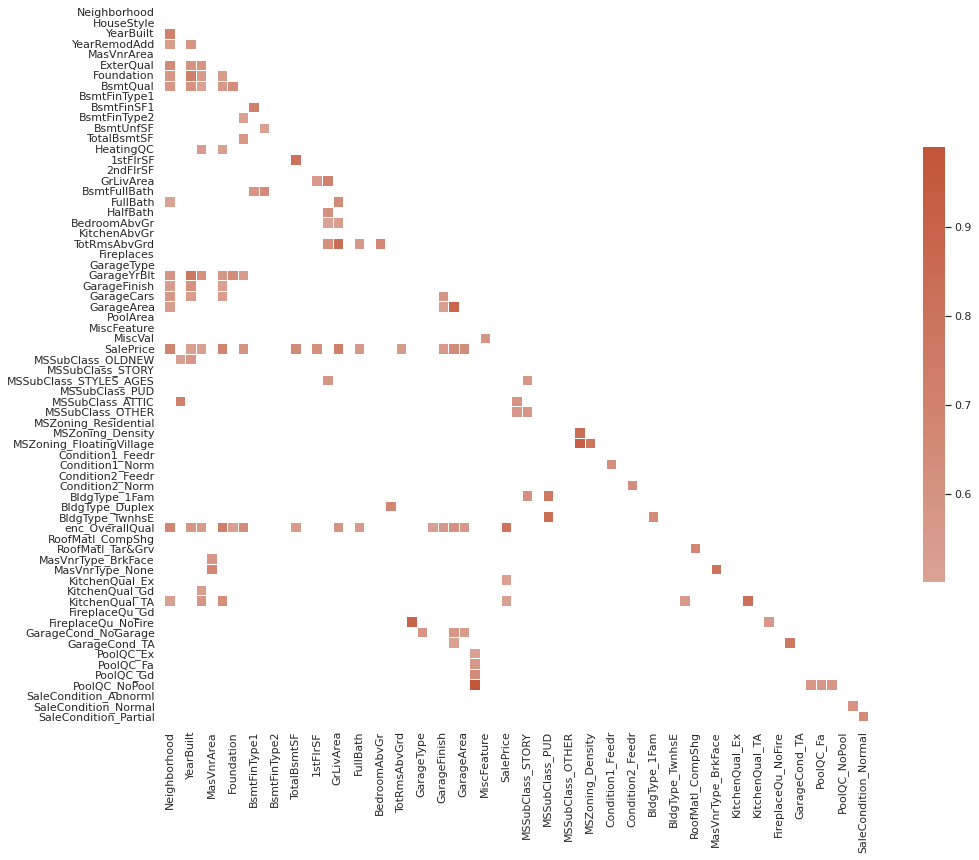

In [217]:
corr = data.corr().abs().replace(1, np.nan) \
    .apply(lambda x: np.where(x < 0.5,np.nan,x)).dropna(axis=1, how='all') \
    .apply(lambda x: np.where(x < 0.5,np.nan,x)).dropna(axis=0, how='all')

sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [218]:
# Test General normalization
#data = (data-data.mean())/data.std()
#data = (data-data.min())/(data.max()-data.min()) # Gives worst results

### Split data

In [219]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [220]:
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

# Modeling

In [221]:
df_result = pd.DataFrame(columns=['Method','RMSE','GridParams'])

In [222]:
def rmse(df, model):
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return df.append({'Method':model.__class__.__name__, 'RMSE':rmse}, ignore_index=True)

def grid_rmse(df, grid):
    rmse = np.sqrt(np.sqrt(np.abs(grid.best_score_)))
    if hasattr(grid, 'best_params_'):
        params = grid.best_params_
    return df.append({'Method':"{} Grid".format(grid.estimator.__class__.__name__), 'RMSE':rmse, 'GridParams':params}, ignore_index=True)

## Linear Regression

In [223]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
#print ("Root Square is: \n", lr.score(X_test, y_test))
#print ('RMSE is: \n', mean_squared_error(y_test, predictions, squared=False))

# Add to the main array
df_result = rmse(df_result, lr)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN


## Ridge Regression

### Grid Search

In [224]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
ridge_model = linear_model.Ridge()
grid = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])})

In [225]:
grid.best_estimator_

Ridge()

In [226]:
grid.best_params_

{'alpha': 1.0}

In [227]:
print(grid.best_estimator_)
df_result = grid_rmse(df_result, grid)

Ridge()


### Simple

In [228]:
ridge_model = linear_model.Ridge(alpha=grid.best_estimator_.alpha)
ridge_model.fit(X_train, y_train)
preds_ridge = ridge_model.predict(X_test)
print(ridge_model.score(X_test, y_test))
print("Ridge Regression RMSE: {}".format(mean_squared_error(y_test, preds_ridge, squared=False)))
df_result = rmse(df_result, ridge_model)
df_result

0.918855608921167
Ridge Regression RMSE: 0.11186139849412807


,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN


## Lasso

In [229]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
lasso_model = linear_model.Lasso()
grid_lasso = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=alphas))
grid_lasso.fit(X_train, y_train)
df_result = grid_rmse(df_result, grid_lasso)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}


## Random Forest

### Grid Search

In [230]:
# Search Ranfom Forest Grid
do_rf_grid = False

In [231]:
if do_rf_grid:
    rf_params = {'n_estimators': range(150, 600, 10), 'max_depth': range(3, 15, 1),'min_samples_leaf':[0.04,0.06,0.08,0.1,0.12,0.14], 'max_features':[0.2,0.4,0.6,0.8]}

    grid_rf = GridSearchCV(estimator = RandomForestRegressor(),
                         param_grid = rf_params,
                         cv=10,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         n_jobs=-1)
    grid_rf.fit(X_train, y_train)
    df_result = grid_rmse(df_result, grid_rf)
    print('Best parameters found for rf: ', grid_rf.best_params_)
    print('Lowerst RMSE found for rf: ', np.sqrt(np.sqrt(np.abs(grid_rf.best_score_))))

### Simple

In [232]:
rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf=0.12, random_state=123)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest RMSE: {} ".format(mean_squared_error(y_test, rf_pred,squared=False)))
df_result = rmse(df_result, rf)
df_result

Random Forest RMSE: 0.22644497387123813 


,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN


## Bayesian Regression

In [233]:
bayesridge_model = linear_model.BayesianRidge()
bayesridge_model.fit(X_train, y_train)
df_result = rmse(df_result, bayesridge_model)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN
5,BayesianRidge,0.112414,NaN


## Logistic Regression

In [234]:
#clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#df_result = rmse(df_result, clf)
#df_result

## CatBoost Regressor

In [235]:
cbr = CatBoostRegressor().fit(X_train,y_train)
df_result = rmse(df_result, cbr)
df_result

Learning rate set to 0.038841
0:	learn: 0.3911052	total: 48ms	remaining: 48s
1:	learn: 0.3815897	total: 49.6ms	remaining: 24.7s
2:	learn: 0.3724318	total: 51ms	remaining: 16.9s
3:	learn: 0.3630734	total: 52.3ms	remaining: 13s
4:	learn: 0.3546845	total: 53.8ms	remaining: 10.7s
5:	learn: 0.3454951	total: 55.1ms	remaining: 9.13s
6:	learn: 0.3383978	total: 56.3ms	remaining: 7.98s
7:	learn: 0.3308557	total: 57.4ms	remaining: 7.12s
8:	learn: 0.3232182	total: 58.5ms	remaining: 6.45s
9:	learn: 0.3164913	total: 59.6ms	remaining: 5.9s
10:	learn: 0.3102451	total: 60.7ms	remaining: 5.46s
11:	learn: 0.3037277	total: 62ms	remaining: 5.11s
12:	learn: 0.2974786	total: 63.2ms	remaining: 4.79s
13:	learn: 0.2914498	total: 64.4ms	remaining: 4.54s
14:	learn: 0.2856612	total: 65.7ms	remaining: 4.32s
15:	learn: 0.2800377	total: 67.5ms	remaining: 4.15s
16:	learn: 0.2737918	total: 68.5ms	remaining: 3.96s
17:	learn: 0.2679177	total: 69.6ms	remaining: 3.8s
18:	learn: 0.2624091	total: 70.7ms	remaining: 3.65s
19:	

183:	learn: 0.0949125	total: 252ms	remaining: 1.11s
184:	learn: 0.0947235	total: 253ms	remaining: 1.11s
185:	learn: 0.0946136	total: 254ms	remaining: 1.11s
186:	learn: 0.0944807	total: 255ms	remaining: 1.11s
187:	learn: 0.0942113	total: 256ms	remaining: 1.1s
188:	learn: 0.0940301	total: 257ms	remaining: 1.1s
189:	learn: 0.0938050	total: 258ms	remaining: 1.1s
190:	learn: 0.0936851	total: 259ms	remaining: 1.1s
191:	learn: 0.0933873	total: 260ms	remaining: 1.1s
192:	learn: 0.0931215	total: 262ms	remaining: 1.09s
193:	learn: 0.0930147	total: 263ms	remaining: 1.09s
194:	learn: 0.0928815	total: 264ms	remaining: 1.09s
195:	learn: 0.0927302	total: 265ms	remaining: 1.09s
196:	learn: 0.0926107	total: 266ms	remaining: 1.08s
197:	learn: 0.0924504	total: 267ms	remaining: 1.08s
198:	learn: 0.0923799	total: 268ms	remaining: 1.08s
199:	learn: 0.0921353	total: 269ms	remaining: 1.08s
200:	learn: 0.0919311	total: 270ms	remaining: 1.07s
201:	learn: 0.0918232	total: 271ms	remaining: 1.07s
202:	learn: 0.091

360:	learn: 0.0711529	total: 445ms	remaining: 788ms
361:	learn: 0.0711405	total: 446ms	remaining: 786ms
362:	learn: 0.0710048	total: 447ms	remaining: 785ms
363:	learn: 0.0709616	total: 448ms	remaining: 783ms
364:	learn: 0.0708285	total: 450ms	remaining: 782ms
365:	learn: 0.0706881	total: 451ms	remaining: 781ms
366:	learn: 0.0706423	total: 452ms	remaining: 779ms
367:	learn: 0.0705540	total: 453ms	remaining: 778ms
368:	learn: 0.0705080	total: 454ms	remaining: 776ms
369:	learn: 0.0704514	total: 455ms	remaining: 775ms
370:	learn: 0.0703227	total: 457ms	remaining: 774ms
371:	learn: 0.0701904	total: 458ms	remaining: 773ms
372:	learn: 0.0700917	total: 459ms	remaining: 771ms
373:	learn: 0.0700277	total: 460ms	remaining: 770ms
374:	learn: 0.0699962	total: 461ms	remaining: 768ms
375:	learn: 0.0699142	total: 462ms	remaining: 767ms
376:	learn: 0.0697672	total: 463ms	remaining: 765ms
377:	learn: 0.0696522	total: 464ms	remaining: 764ms
378:	learn: 0.0695251	total: 465ms	remaining: 762ms
379:	learn: 

535:	learn: 0.0565241	total: 639ms	remaining: 553ms
536:	learn: 0.0564364	total: 640ms	remaining: 552ms
537:	learn: 0.0563521	total: 642ms	remaining: 551ms
538:	learn: 0.0562664	total: 643ms	remaining: 550ms
539:	learn: 0.0561789	total: 644ms	remaining: 549ms
540:	learn: 0.0561089	total: 645ms	remaining: 547ms
541:	learn: 0.0560407	total: 646ms	remaining: 546ms
542:	learn: 0.0559709	total: 647ms	remaining: 545ms
543:	learn: 0.0559336	total: 648ms	remaining: 543ms
544:	learn: 0.0558759	total: 649ms	remaining: 542ms
545:	learn: 0.0558661	total: 650ms	remaining: 541ms
546:	learn: 0.0557930	total: 652ms	remaining: 540ms
547:	learn: 0.0557578	total: 653ms	remaining: 538ms
548:	learn: 0.0556384	total: 654ms	remaining: 537ms
549:	learn: 0.0555448	total: 655ms	remaining: 536ms
550:	learn: 0.0555031	total: 656ms	remaining: 535ms
551:	learn: 0.0554554	total: 657ms	remaining: 533ms
552:	learn: 0.0554231	total: 658ms	remaining: 532ms
553:	learn: 0.0553896	total: 659ms	remaining: 531ms
554:	learn: 

710:	learn: 0.0456046	total: 833ms	remaining: 339ms
711:	learn: 0.0455486	total: 835ms	remaining: 338ms
712:	learn: 0.0454526	total: 836ms	remaining: 336ms
713:	learn: 0.0453541	total: 837ms	remaining: 335ms
714:	learn: 0.0453496	total: 838ms	remaining: 334ms
715:	learn: 0.0452934	total: 839ms	remaining: 333ms
716:	learn: 0.0452355	total: 840ms	remaining: 332ms
717:	learn: 0.0451514	total: 841ms	remaining: 330ms
718:	learn: 0.0450984	total: 842ms	remaining: 329ms
719:	learn: 0.0450829	total: 843ms	remaining: 328ms
720:	learn: 0.0450152	total: 844ms	remaining: 327ms
721:	learn: 0.0449817	total: 845ms	remaining: 326ms
722:	learn: 0.0449014	total: 847ms	remaining: 324ms
723:	learn: 0.0448614	total: 848ms	remaining: 323ms
724:	learn: 0.0447864	total: 849ms	remaining: 322ms
725:	learn: 0.0447092	total: 850ms	remaining: 321ms
726:	learn: 0.0446574	total: 851ms	remaining: 320ms
727:	learn: 0.0446071	total: 852ms	remaining: 318ms
728:	learn: 0.0445746	total: 853ms	remaining: 317ms
729:	learn: 

884:	learn: 0.0367665	total: 1.03s	remaining: 133ms
885:	learn: 0.0367192	total: 1.03s	remaining: 132ms
886:	learn: 0.0367146	total: 1.03s	remaining: 131ms
887:	learn: 0.0366763	total: 1.03s	remaining: 130ms
888:	learn: 0.0366255	total: 1.03s	remaining: 129ms
889:	learn: 0.0365832	total: 1.03s	remaining: 128ms
890:	learn: 0.0365342	total: 1.03s	remaining: 126ms
891:	learn: 0.0364658	total: 1.03s	remaining: 125ms
892:	learn: 0.0364009	total: 1.03s	remaining: 124ms
893:	learn: 0.0363761	total: 1.04s	remaining: 123ms
894:	learn: 0.0363089	total: 1.04s	remaining: 122ms
895:	learn: 0.0362673	total: 1.04s	remaining: 121ms
896:	learn: 0.0362360	total: 1.04s	remaining: 119ms
897:	learn: 0.0362105	total: 1.04s	remaining: 118ms
898:	learn: 0.0361695	total: 1.04s	remaining: 117ms
899:	learn: 0.0361314	total: 1.04s	remaining: 116ms
900:	learn: 0.0360956	total: 1.04s	remaining: 115ms
901:	learn: 0.0360256	total: 1.04s	remaining: 114ms
902:	learn: 0.0359739	total: 1.04s	remaining: 112ms
903:	learn: 

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN
5,BayesianRidge,0.112414,NaN
6,CatBoostRegressor,0.114850,NaN


## XGBoost

### Grid Search

In [236]:
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9], 'n_estimators': [200], 'subsample':[0.3,0.5,0.9]}
grid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'), param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_xgb.fit(X_train,y_train)
df_result = grid_rmse(df_result, grid_xgb)
df_result

Fitting 4 folds for each of 12 candidates, totalling 48 fits


,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN
5,BayesianRidge,0.112414,NaN
6,CatBoostRegressor,0.114850,NaN
7,XGBRegressor Grid,0.367286,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."


In [237]:
xgbm = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.01,
                max_depth=5, alpha = 10, n_estimators = 1000)
xgbm.fit(X_train,y_train)
df_result = rmse(df_result, xgbm)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN
5,BayesianRidge,0.112414,NaN
6,CatBoostRegressor,0.114850,NaN
7,XGBRegressor Grid,0.367286,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
8,XGBRegressor,0.146397,NaN


In [238]:
# Intermediate results
print(df_result['RMSE'].to_string(index=False))

0.114211
0.970092
0.111861
0.971946
0.226445
0.112414
0.114850
0.367286
0.146397


## Gradient Boost Regressor

In [239]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]}

kfold = KFold(n_splits=num_folds)
grid_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid_gb.fit(X=rescaledX, y=y_train)

df_result = grid_rmse(df_result, grid_gb)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN
5,BayesianRidge,0.112414,NaN
6,CatBoostRegressor,0.114850,NaN
7,XGBRegressor Grid,0.367286,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
8,XGBRegressor,0.146397,NaN
9,GradientBoostingRegressor Grid,0.364403,{'n_estimators': 300}


## Extra Trees Regressor

In [240]:
etr_model = ExtraTreesRegressor(n_estimators=80)
etr_model.fit(X=X_train, y=y_train)
df_result = rmse(df_result, etr_model)
df_result

,Method,RMSE,GridParams
0,LinearRegression,0.114211,NaN
1,Ridge Grid,0.970092,{'alpha': 1.0}
2,Ridge,0.111861,NaN
3,Lasso Grid,0.971946,{'alpha': 0.001}
4,RandomForestRegressor,0.226445,NaN
5,BayesianRidge,0.112414,NaN
6,CatBoostRegressor,0.114850,NaN
7,XGBRegressor Grid,0.367286,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
8,XGBRegressor,0.146397,NaN
9,GradientBoostingRegressor Grid,0.364403,{'n_estimators': 300}


# Results

In [241]:
df_result.sort_values(by='RMSE')

,Method,RMSE,GridParams
2,Ridge,0.111861,NaN
5,BayesianRidge,0.112414,NaN
0,LinearRegression,0.114211,NaN
6,CatBoostRegressor,0.114850,NaN
10,ExtraTreesRegressor,0.130227,NaN
8,XGBRegressor,0.146397,NaN
4,RandomForestRegressor,0.226445,NaN
9,GradientBoostingRegressor Grid,0.364403,{'n_estimators': 300}
7,XGBRegressor Grid,0.367286,"{'learning_rate': 0.1, 'n_estimators': 200, 's..."
1,Ridge Grid,0.970092,{'alpha': 1.0}


In [242]:
print(df_result['RMSE'].to_string(index=False))

0.114211
0.970092
0.111861
0.971946
0.226445
0.112414
0.114850
0.367286
0.146397
0.364403
0.130227
